In [7]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
import glob
import librosa
import numpy as np
import librosa.display
import moviepy.editor as mp
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale
from Audio_Sentiment_Analysis.utils.Configuration import Configuration

In [3]:
AUDIO_DIR = f"{os.path.abspath('./../../')}/eNTERFACE05_Dataset"
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"
config = Configuration.load_json(CONFIG_FILE)

In [36]:
def extract_features(audio_file, subject, emotion, analysis=False):
    y, sr = librosa.load(audio_file, res_type='kaiser_fast')

    file = audio_file.split(".")[-2].split("\\")[-1]
    rms = librosa.feature.rms(y)
    chroma_stft = librosa.feature.chroma_stft(y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y, sr=sr)
    spec_cont = librosa.feature.spectral_contrast(y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y, sr=sr)
    spec_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y, sr=sr)
    mel_spect = librosa.feature.melspectrogram(y, sr=sr, n_mels=config.n_mels)

    if analysis:
        return [
            file, subject, emotion, mel_spect, mfcc, np.mean(chroma_stft), np.mean(rms), np.mean(spec_cent),\
            np.mean(spec_cont), np.mean(spec_bw), np.mean(spec_rolloff), np.mean(zcr)
        ]

    features_str = f'{file} {subject} {emotion} {np.mean(mel_spect)} {np.min(mel_spect)} {np.max(mel_spect)} {np.var(mel_spect)} {np.std(mel_spect)}\
        {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_cont)} {np.mean(spec_bw)} {np.mean(spec_rolloff)} {np.mean(zcr)}'

    for e in mfcc:
        features_str += f' {np.mean(e)}'

    return features_str.split()

In [19]:
def process_data(audio_dir, proc_feat_dataset):
    # Create a CSV for storing all processed features and write the header
    header = 'File Subject Emotion mel_mean mel_min mel_max mel_var mel_std chroma_stft rmse spectral_centroid spectral_contrast spectral_bandwidth spectral_rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header = header.split()
    file = open(proc_feat_dataset, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(header)

    print("Processing audio files from all subjects:")
    for file_path in tqdm(glob.glob(audio_dir+'/*/*/*/*.avi')):
        labels =  file_path.split('\\')
        # labels =  file_path.split('/')
        subject = labels[-4].split()[1]
        emotion = labels[-3]

        audio_file_path = file_path[:-3] + 'wav'
        # convert file type to wav
        if not os.path.isfile(audio_file_path):
            audio_clip = mp.VideoFileClip(file_path)
            audio_clip.audio.write_audiofile(audio_file_path)
        file_path = audio_file_path

        processed_data = extract_features(file_path, subject, emotion)
        writer.writerow(processed_data)

In [20]:
process_data(AUDIO_DIR, EXTRACTED_FEATURES_FILE)

Processing audio files from all subjects:


100%|██████████| 1287/1287 [01:08<00:00, 18.80it/s]


In [53]:
columns = ['File', 'Subject', 'Emotion',  'mel_spect', 'mfcc', 'chroma_stft', 'rms', 'spec_cent', 'spec_cont', 'spec_bw', 'spec_rolloff', 'zcr']
df = pd.DataFrame(columns=columns)

# Taking only one file per emotion for analysis purposes
for file_path in glob.glob(AUDIO_DIR+"/*/*/sentence 1/*.wav"):
    labels =  file_path.split('\\')
    # labels =  file_path.split('/')
    subject = labels[-4].split()[1]
    emotion = labels[-3]

    features = extract_features(file_path, subject, emotion, analysis=True)

    df = df.append(pd.DataFrame(features, index=columns).transpose(), ignore_index=True)

df = df.sort_values(['Subject', 'Emotion'], ascending = (True, True))
df = df.set_index('Subject')

df[df.columns[4:]] = minmax_scale(df[df.columns[4:]])
df


,File,Emotion,mel_spect,mfcc,chroma_stft,rms,spec_cent,spec_cont,spec_bw,spec_rolloff,zcr
Subject,,,,,,,,,,,
1,s1_an_1,anger,"[[0.002001118, 0.0017819229, 0.0017195621, 0.0...","[[-429.37125, -428.35626, -430.707, -424.46725...",0.55891,0.862407,0.234403,0.784797,0.341579,0.33249,0.207454
1,s1_di_1,disgust,"[[0.00061486254, 0.00031024398, 0.0005338352, ...","[[-442.08148, -438.0669, -432.90442, -431.6646...",0.313596,0.676152,0.122728,0.880197,0.194388,0.149875,0.163623
1,s1_fe_1,fear,"[[0.00077908766, 0.0005726051, 0.00046864187, ...","[[-449.71625, -437.88364, -437.4251, -436.3283...",0.334125,0.479967,0.239993,0.896444,0.271528,0.230127,0.249416
1,s1_ha_1,happiness,"[[0.05813717, 0.015589418, 0.00064850575, 0.00...","[[-400.10773, -401.39014, -407.40433, -407.352...",0.361318,0.626763,0.292819,0.717949,0.346011,0.315347,0.28742
1,s1_sa_1,sadness,"[[0.0002053016, 0.00040284405, 0.00055165763, ...","[[-461.70282, -455.24207, -454.9842, -453.6672...",0.402427,0.312959,0.224946,0.79337,0.35845,0.248238,0.197128
...,...,...,...,...,...,...,...,...,...,...,...
9,s9_di_1,disgust,"[[0.0048020855, 0.0012785012, 0.00027633575, 0...","[[-437.90894, -434.498, -438.48044, -439.91937...",0.771121,0.267304,0.534299,0.504193,0.472189,0.514912,0.64304
9,s9_fe_1,fear,"[[0.0006742036, 0.0005168695, 0.00088045176, 0...","[[-437.20267, -432.35385, -430.27075, -430.812...",0.720846,0.178433,0.555972,0.478695,0.583778,0.612643,0.651193
9,s9_ha_1,happiness,"[[0.0017317393, 0.0008586449, 0.0003381166, 0....","[[-432.48572, -431.80383, -439.24753, -440.831...",0.91874,0.163724,0.579769,0.383042,0.590086,0.649009,0.732994


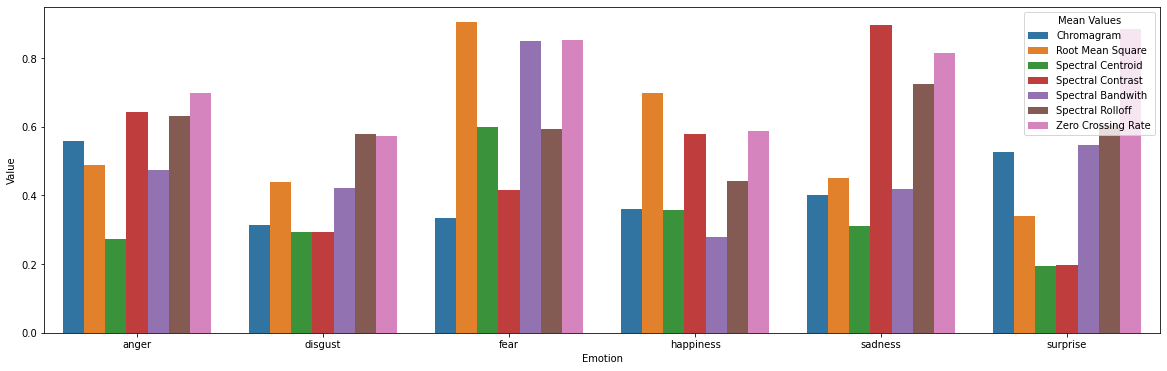

In [55]:
df_barplot = pd.DataFrame(
    zip(
        list(df['Emotion'].values)*6,
        ["Chromagram"]*6+["Root Mean Square"]*6+["Spectral Centroid"]*6+["Spectral Contrast"]*6+["Spectral Bandwith"]*6+\
            ["Spectral Rolloff"]*6+["Zero Crossing Rate"]*6,
        list(df['chroma_stft'].values)+list(df['rms'].values)+list(df['spec_cent'].values)+list(df['spec_cont'].values)+\
            list(df['spec_bw'].values)+list(df['spec_rolloff'].values)+list(df['zcr'].values)
    ),
    columns=["Emotion", "Mean Values", 'Value']
)

plt.figure(figsize=(20, 6))
sns.barplot(x="Emotion", hue="Mean Values", y="Value", data=df_barplot)
plt.show()